In [16]:
import torch 
from torch_geometric.data import Data

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.utils import add_self_loops, degree

import numpy as np

In [90]:
class MPGNN(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="mean")
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        return self.linear(x_j)
    
    def update(self, aggr_out):
        return F.tanh(aggr_out)

In [ ]:
class GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = MPGNN(in_dim, hidden_dim)
        self.conv2 = MPGNN(hidden_dim, hidden_dim)
        self.conv3 = MPGNN(hidden_dim, hidden_dim)
        self.conv4 = MPGNN(hidden_dim, out_dim)

        

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        x = self.conv4(x, edge_index)
        return x


In [120]:
l_n = 1.0

num_nodes = 20
dx = l_n / (num_nodes - 1) # Distance between nodes

edge_index = []

for i in range(num_nodes - 1):
    edge_index.append([i, i + 1])  # Forward connection
    edge_index.append([i + 1, i])  # Backward connection

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

edge_attr = torch.tensor([dx] * edge_index.shape[1], dtype=torch.float).view(-1, 1)
node_pos = torch.tensor([[i * dx] for i in range(num_nodes)], dtype=torch.float)  

beam_graph = Data(x=node_pos, edge_index=edge_index, edge_attr=edge_attr)
beam_graph.x.requires_grad = True

print(beam_graph)

Data(x=[20, 1], edge_index=[2, 38], edge_attr=[38, 1])


In [155]:
def create_beam_graph(num_nodes):
    dx = 1 / (num_nodes - 1)

    edge_index = []

    for i in range(num_nodes - 1):
        edge_index.append([i, i + 1])  # Forward connection
        edge_index.append([i + 1, i])  # Backward connection

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    edge_attr = torch.tensor([dx] * edge_index.shape[1], dtype=torch.float).view(-1, 1)
    node_pos = torch.tensor([[i * dx] for i in range(num_nodes)], dtype=torch.float)  

    beam_graph = Data(x=node_pos, edge_index=edge_index, edge_attr=edge_attr)
    beam_graph.x.requires_grad = True

    return beam_graph
    

In [129]:

E = 70e9
I = 0.1**4 / 12 # Square cross section with lenght 0.1m
EI = E * I
print(EI)
L = 3.0
Q = -20000

x = beam_graph.x[:,0:1]
x_pred = x * L

q1 = lambda x: Q / (24*EI) * (x**4 - 4*L*x**3 + 6*L**2*x**2) # Fixed, free, constant q
q0 = np.max(np.abs(Q))
print(q0)
q_hat = Q / q0
print(q_hat)

exact = q1(x_pred).detach()
print(exact)

583333.3333333335
20000
-1.0
tensor([[-0.0000],
        [-0.0019],
        [-0.0072],
        [-0.0156],
        [-0.0267],
        [-0.0402],
        [-0.0558],
        [-0.0732],
        [-0.0922],
        [-0.1124],
        [-0.1337],
        [-0.1559],
        [-0.1787],
        [-0.2021],
        [-0.2259],
        [-0.2499],
        [-0.2741],
        [-0.2984],
        [-0.3228],
        [-0.3471]])


In [ ]:
class PINN_graph():
    def __init__(self, graph, q, exact):
        
        self.graph = graph

        self.input_dim = 1
        self.hidden_dim = 32
        self.output_dim = 2

        self.q = q

        self.lb = 'fixed'
        self.rb = 'free'

        self.gnn = GNN(self.input_dim, self.hidden_dim, self.output_dim)

        self.optimizer = torch.optim.Adam(self.gnn.parameters(), lr=0.01)
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.gnn.parameters(),
            lr=0.01,
            max_iter=5000,
            max_eval=5000,
            history_size=200,
            tolerance_grad=1e-20,
            tolerance_change=1e-20,
        )
        self.iter = 0

    def model_value(self, graph):
        out = self.gnn(graph)
        u = out[:, 0:1]
        m = out[:, 1:2]
        return u, m
    
    def boundary_cond(self, cond, u, u_x, m, m_x):
        bc_loss = 0

        match cond:
            case 'pinned':
                bc_loss += u**2 + m**2
            case 'fixed':
                bc_loss += u**2 + u_x**2
            case 'free':
                bc_loss += m**2 + m_x**2
            case 'roller':
                bc_loss += u_x**2 + m_x**2
        return bc_loss

    def loss_func(self, graph):
        x = graph.x
        u, m = self.model_value(graph)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]

        # BC
        bc_loss = self.boundary_cond(self.lb, u[0], u_x[0], m[0], m_x[0])
        bc_loss += self.boundary_cond(self.rb, u[-1], u_x[-1], m[-1], m_x[-1])

        # PDE
        pde_loss = torch.mean(torch.pow(m_2x + self.q, 2))
        pde_loss += torch.mean(torch.pow(u_2x + m, 2))

        # Data
        qc = (L**4 * q0 / EI)
        data_loss = torch.mean(torch.pow(u*qc - exact, 2))

        return pde_loss + bc_loss + data_loss
    
    def lbfgs_func(self):
        loss = self.loss_func(self.graph)
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss



    def train(self, epochs=1000):
        self.gnn.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.loss_func(self.graph)
            loss.backward()
            self.optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, Loss: {'{:e}'.format(loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)



In [168]:
model = PINN_graph(beam_graph, -1)

In [169]:
out = model.model_value(beam_graph)
print(out)

(tensor([[-0.3895],
        [-0.3893],
        [-0.3886],
        [-0.3875],
        [-0.3860],
        [-0.3839],
        [-0.3814],
        [-0.3785],
        [-0.3751],
        [-0.3713],
        [-0.3671],
        [-0.3625],
        [-0.3576],
        [-0.3524],
        [-0.3470],
        [-0.3413],
        [-0.3355],
        [-0.3301],
        [-0.3259],
        [-0.3240]], grad_fn=<SliceBackward0>), tensor([[-0.1233],
        [-0.1235],
        [-0.1238],
        [-0.1242],
        [-0.1244],
        [-0.1245],
        [-0.1244],
        [-0.1240],
        [-0.1236],
        [-0.1230],
        [-0.1222],
        [-0.1213],
        [-0.1204],
        [-0.1193],
        [-0.1182],
        [-0.1171],
        [-0.1159],
        [-0.1149],
        [-0.1141],
        [-0.1137]], grad_fn=<SliceBackward0>))


In [170]:
model.train(4000)

Epoch: 0, Loss: 1.877044e+00
Epoch: 100, Loss: 1.356599e-02
Epoch: 200, Loss: 9.312392e-03
Epoch: 300, Loss: 8.961484e-03
Epoch: 400, Loss: 9.840502e-03
Epoch: 500, Loss: 8.792136e-03
Epoch: 600, Loss: 8.625181e-03
Epoch: 700, Loss: 8.459111e-03
Epoch: 800, Loss: 8.411800e-03
Epoch: 900, Loss: 8.257374e-03
Epoch: 1000, Loss: 8.185735e-03
Epoch: 1100, Loss: 8.270968e-03
Epoch: 1200, Loss: 8.190359e-03
Epoch: 1300, Loss: 8.143907e-03
Epoch: 1400, Loss: 8.119159e-03
Epoch: 1500, Loss: 8.131923e-03
Epoch: 1600, Loss: 8.095365e-03
Epoch: 1700, Loss: 8.656986e-03
Epoch: 1800, Loss: 8.083830e-03
Epoch: 1900, Loss: 8.037121e-03
Epoch: 2000, Loss: 8.040565e-03
Epoch: 2100, Loss: 8.137826e-03
Epoch: 2200, Loss: 8.025722e-03
Epoch: 2300, Loss: 8.043658e-03
Epoch: 2400, Loss: 8.574395e-03
Epoch: 2500, Loss: 8.126062e-03
Epoch: 2600, Loss: 8.333390e-03
Epoch: 2700, Loss: 7.966729e-03
Epoch: 2800, Loss: 8.806628e-03
Epoch: 2900, Loss: 7.847194e-03
Epoch: 3000, Loss: 7.818114e-03
Epoch: 3100, Loss: 8

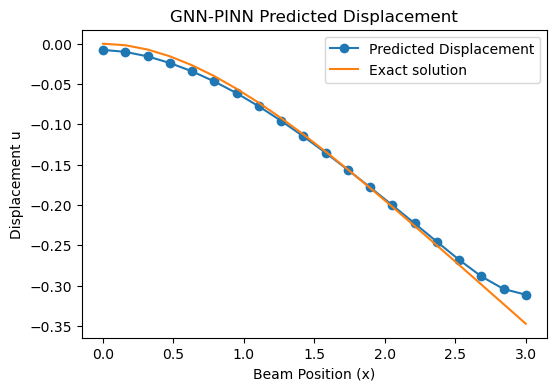

In [171]:
model.gnn.eval()

u, m = model.model_value(beam_graph)
u_pred = (L**4 * q0 / EI) * u.detach().cpu().numpy()
m_pred = (L**2 * q0) * m.detach().cpu().numpy()


u_exact = exact.numpy()

plt.figure(figsize=(6, 4))
plt.plot(x, u_pred, 'o-', label="Predicted Displacement")
plt.plot(x, u_exact, label="Exact solution")
plt.xlabel("Beam Position (x)")
plt.ylabel("Displacement u")
plt.title("GNN-PINN Predicted Displacement")
plt.legend()
plt.show()


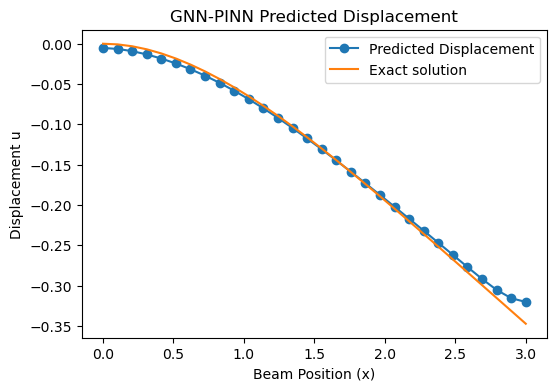

In [172]:
model.gnn.eval()

second_beam = create_beam_graph(30)

u, m = model.model_value(second_beam)
u_pred = (L**4 * q0 / EI) * u.detach().cpu().numpy()
m_pred = (L**2 * q0) * m.detach().cpu().numpy()

x_pred = second_beam.x.detach().cpu().numpy() * L

u_exact = q1(x_pred)

plt.figure(figsize=(6, 4))
plt.plot(x_pred, u_pred, 'o-', label="Predicted Displacement")
plt.plot(x_pred, u_exact, label="Exact solution")
plt.xlabel("Beam Position (x)")
plt.ylabel("Displacement u")
plt.title("GNN-PINN Predicted Displacement")
plt.legend()
plt.show()
